## csca-5632-unsupervised-algorithms-in-machine-learning-final-project
## Problem Statement

The proliferation of wearable devices and smartphones equipped with sensors like accelerometers and gyroscopes has enabled continuous monitoring of human physical activities.
Recognizing and classifying these activities can have significant applications in healthcare, sports, and human-computer interaction.

This project aims to perform unsupervised clustering on the Human Activity Recognition (HAR) dataset using data collected from smartphones. By clustering the sensor data, we aim to identify patterns in human movements and potentially recognize different activities without relying on labeled data.


## Dataset Description

The UCI HAR Dataset contains recordings of 30 subjects performing activities of daily living (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) while carrying a waist-mounted smartphone with embedded inertial sensors. The dataset includes:

* Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
* Triaxial Angular velocity from the gyroscope.
* A 561-feature vector with time and frequency domain variables.
* Its activity label. 
* An identifier of the subject who carried out the experiment.

The dataset includes the following files:
=========================================

- 'README.txt'

- 'features_info.txt': Shows information about the variables used on the feature vector.

- 'features.txt': List of all features.

- 'activity_labels.txt': Links the class labels with their activity name.

- 'train/X_train.txt': Training set.

- 'train/y_train.txt': Training labels.

- 'test/X_test.txt': Test set.

- 'test/y_test.txt': Test labels.

The following files are available for the train and test data. 

- 'train/subject_train.txt': Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 

- 'train/Inertial Signals/total_acc_x_train.txt': The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. The same description applies for the 'total_acc_x_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 

- 'train/Inertial Signals/body_acc_x_train.txt': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 

- 'train/Inertial Signals/body_gyro_x_train.txt': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 

Notes: 
======
- Features are normalized and bounded within [-1,1].
- Each feature vector is a row on the text file.
- The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).
- The gyroscope units are rad/seg.
- A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen in the following link: http://www.youtube.com/watch?v=XOEN9W05_4A

Dataset Source: https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

## Data Understanding and EDA

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# For evaluation
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score

from collections import Counter
import warnings

In [2]:
# Load features
feature_names = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None)
feature_names = feature_names[1].values

# Load activity labels
activity_labels = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, index_col=0)
activity_labels = activity_labels[1].to_dict()

# Load training data
X_train = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
X_train.columns = feature_names

y_train = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/train/y_train.txt', sep='\\s+', header=None)
y_train.columns = ['Activity']

subject_train = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/train/subject_train.txt', sep='\\s+', header=None)
subject_train.columns = ['Subject']

# Combine training data
train_data = pd.concat([subject_train, y_train, X_train], axis=1)

# Load test data
X_test = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
X_test.columns = feature_names

y_test = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/test/y_test.txt', sep='\\s+', header=None)
y_test.columns = ['Activity']

subject_test = pd.read_csv('/kaggle/input/uci-har-dataset/UCI HAR Dataset/test/subject_test.txt', sep='\\s+', header=None)
subject_test.columns = ['Subject']

# Combine test data
test_data = pd.concat([subject_test, y_test, X_test], axis=1)

In [3]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Display first few rows
train_data.head()

Shape of X_train: (7352, 561)
Shape of y_train: (7352, 1)
Shape of X_test: (2947, 561)
Shape of y_test: (2947, 1)


,Subject,Activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,1,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


The training data consists of 7,352 samples with 561 features each.

## Data Cleaning and Preprocessing

Check for Missing Values

In [4]:
print("Missing values in training data:", train_data.isnull().sum().sum())
print("Missing values in test data:", test_data.isnull().sum().sum())

Missing values in training data: 0
Missing values in test data: 0


There are no missing values in the data.

In [5]:
# Check data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, Subject to angle(Z,gravityMean)
dtypes: float64(561), int64(2)
memory usage: 31.6 MB


In [6]:
train_data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
Subject,7352.0,17.413085,8.975143,1.000000,8.000000,19.000000,26.000000,30.000000
Activity,7352.0,3.643362,1.744802,1.000000,2.000000,4.000000,5.000000,6.000000
tBodyAcc-mean()-X,7352.0,0.274488,0.070261,-1.000000,0.262975,0.277193,0.288461,1.000000
tBodyAcc-mean()-Y,7352.0,-0.017695,0.040811,-1.000000,-0.024863,-0.017219,-0.010783,1.000000
tBodyAcc-mean()-Z,7352.0,-0.109141,0.056635,-1.000000,-0.120993,-0.108676,-0.097794,1.000000
tBodyAcc-std()-X,7352.0,-0.605438,0.448734,-1.000000,-0.992754,-0.946196,-0.242813,1.000000
tBodyAcc-std()-Y,7352.0,-0.510938,0.502645,-0.999873,-0.978129,-0.851897,-0.034231,0.916238
tBodyAcc-std()-Z,7352.0,-0.604754,0.418687,-1.000000,-0.980233,-0.859365,-0.262415,1.000000
tBodyAcc-mad()-X,7352.0,-0.630512,0.424073,-1.000000,-0.993591,-0.950709,-0.292680,1.000000
tBodyAcc-mad()-Y,7352.0,-0.526907,0.485942,-1.000000,-0.978162,-0.857328,-0.066701,0.967664


### Standardize the Features

Since the features have varying scales, we'll standardize them to have zero mean and unit variance.

In [7]:
# Separate features and labels
X_train_features = X_train.copy()
X_test_features = X_test.copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data
scaler.fit(X_train_features)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

## Exploratory Data Analysis

Due to the high dimensionality of the data (561 features), visualizing all features simultaneously is impractical. However, we can explore correlations and distributions of a subset of features.

## Exploratory Data Analysis
### Understanding the Dataset Structure
Activity Distribution

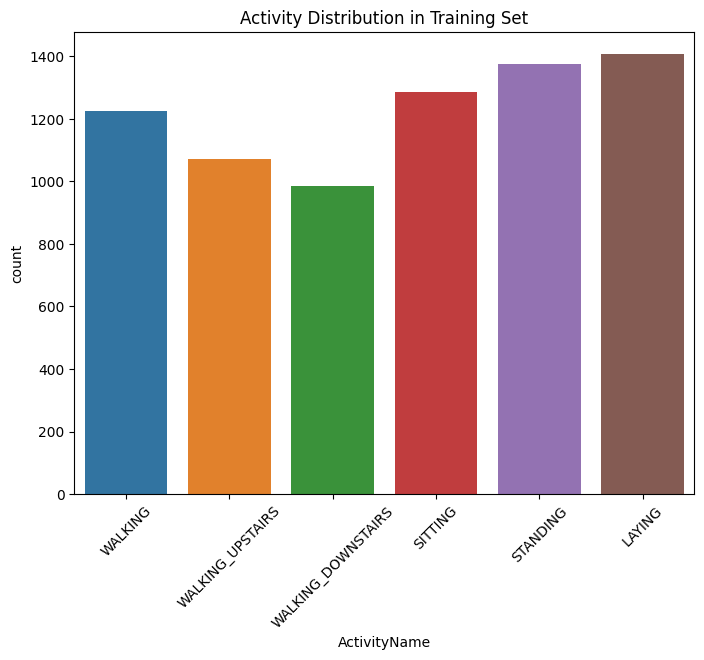

In [8]:
# Map activity labels
train_data['ActivityName'] = train_data['Activity'].map(activity_labels)
test_data['ActivityName'] = test_data['Activity'].map(activity_labels)

# Plot activity distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='ActivityName', data=train_data, order=activity_labels.values())
plt.title('Activity Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

The bar plot shows the number of samples for each activity in the training set. The dataset seems to be well-balanced, meaning that the distribution of activities is balanced across activities.

Subject Distribution

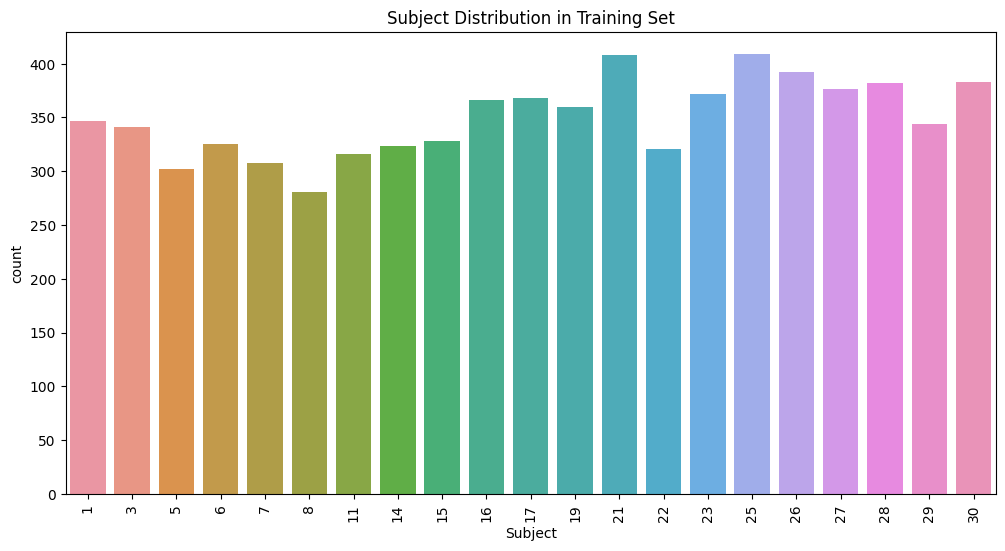

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Subject', data=train_data)
plt.title('Subject Distribution in Training Set')
plt.xticks(rotation=90)
plt.show()

The above graph shows how data is distributed among different subjects and helps identify if any subject has significantly more or fewer samples which does not seem to be the case here.

### Feature Correlation Analysis
Due to the high dimensionality, we'll analyze correlations among a subset of features.

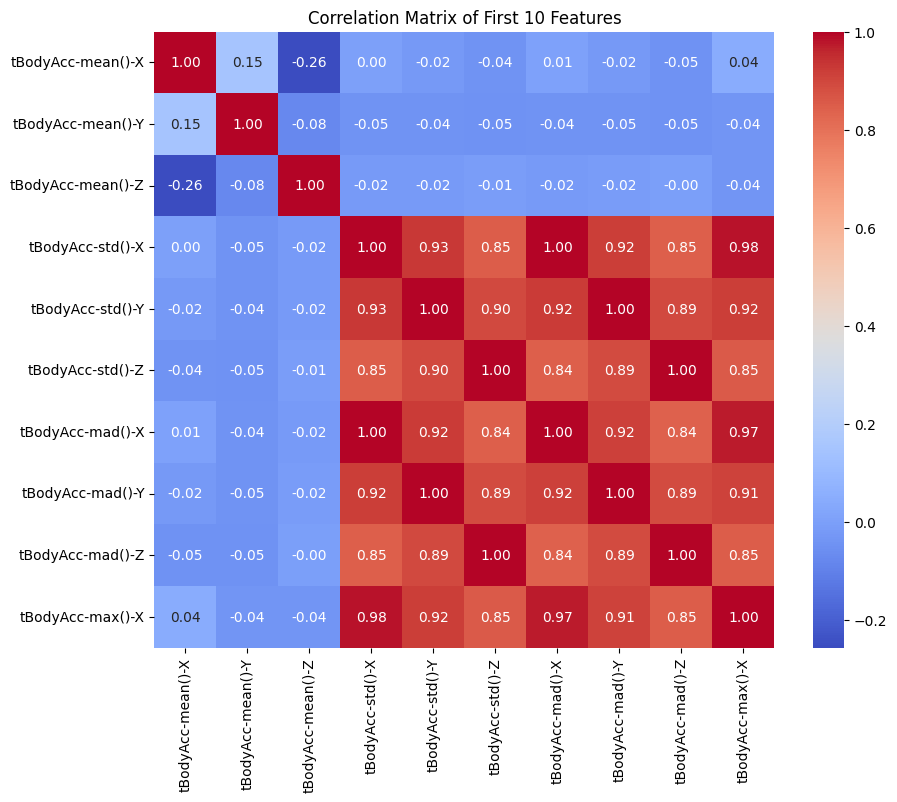

In [10]:
# Compute correlation matrix for a subset of features
subset = X_train.iloc[:, :10]  # Taking first 10 features as an example
corr_matrix = subset.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of First 10 Features')
plt.show()

The heatmap shows how the first 10 features correlate with each other. High correlation between some of these features indicate redundancy, which dimensionality reduction techniques can address.

### Box Plots to Detect Outliers

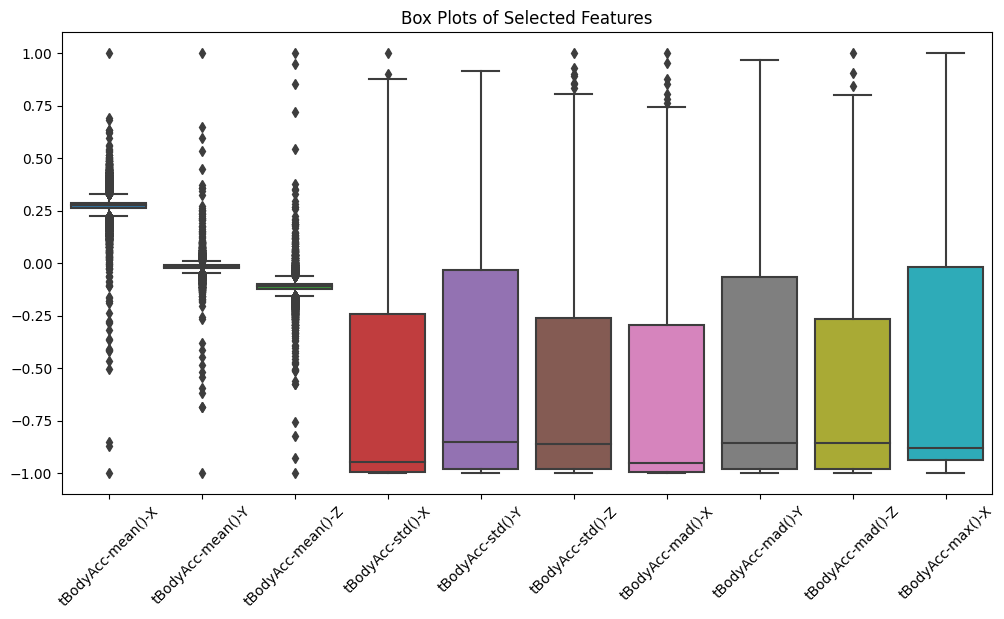

In [11]:
# Box plots for selected features
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset)
plt.title('Box Plots of Selected Features')
plt.xticks(rotation=45)
plt.show()

### Observations

Generated box plots for a subset of features to understand their value ranges and identify potential outliers. Below are key observations:

- **Presence of Outliers**: All features displayed in the box plot exhibit some level of outliers, as indicated by the points beyond the whiskers. This suggests that the dataset contains unusual observations.
- **Distribution Differences**: The **tBodyAcc-mean() features** (X, Y, Z) show noticeable differences in their value distributions. For instance, `tBodyAcc-mean()-Y` has a relatively smaller interquartile range (IQR) compared to `tBodyAcc-mean()-X` and `tBodyAcc-mean()-Z`. This indicates that the range of typical values for acceleration in the Y-axis is more compact, suggesting less variation compared to the other axes.
- **Symmetry and Skewness**: Some features, such as `tBodyAcc-mad()-X`, appear to have a nearly symmetric distribution around the median, while others, like `tBodyAcc-std()-Y`, are more skewed.
- **Comparison of Central Tendencies**: The median values for the features vary significantly. For example, the median of `tBodyAcc-std()-X` is closer to zero, while `tBodyAcc-std()-Y` is shifted below zero. These differences may highlight different movement characteristics along the axes and suggest that clustering models will need to account for the varying nature of central tendencies across features.
- **Variability Across Features**: The **mean absolute deviation (MAD) features** (`tBodyAcc-mad()`) and **standard deviation features** (`tBodyAcc-std()`) exhibit different levels of variability. For example, `tBodyAcc-mad()-Z` has a wider range compared to `tBodyAcc-mad()-Y`, suggesting higher variability in body acceleration along the Z-axis. Features with higher variability could be more informative for distinguishing between different activities.

### Variance Analysis

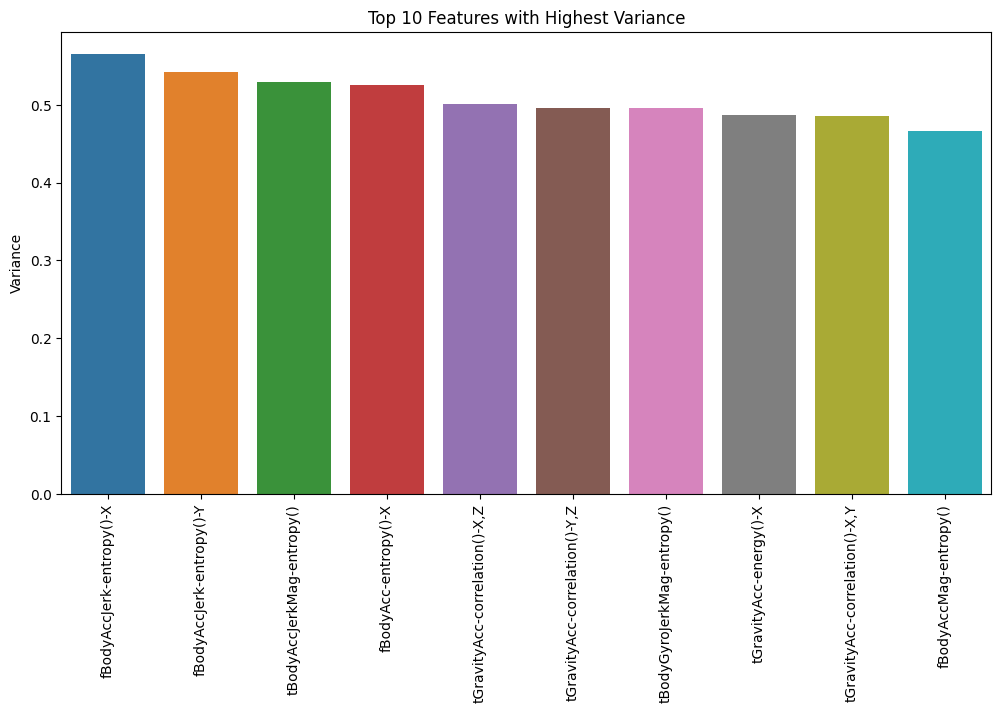

In [12]:
# Compute variance of all features
variances = X_train_features.var()

# Plot top 10 features with highest variance
top_variance_features = variances.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_variance_features.index, y=top_variance_features.values)
plt.title('Top 10 Features with Highest Variance')
plt.xticks(rotation=90)
plt.ylabel('Variance')
plt.show()

### Observations

- **Dominance of Entropy Features**: Many of the top 10 features are related to "entropy" (e.g., `tBodyAcc-entropy()`, `tBodyAccMag-entropy()`, `tBodyGyroJerkMag-entropy()`). Entropy measures the randomness or unpredictability in the signal, indicating that variations in signal irregularity are significant for differentiating between activities.
- **Feature Types**: The high-variance features span multiple sensor types, including accelerometer (`tBodyAcc`), gyroscope (`tBodyGyro`), and gravity acceleration (`tGravityAcc`). This implies that various aspects of movement, such as linear acceleration, rotational movements, and gravitational influence, contribute substantially to explaining the variance in the dataset.
- **Frequency vs. Time Domain**: The features are a mix of time-domain and frequency-domain features. This suggests that both instantaneous movement characteristics and frequency components play important roles in differentiating activities.
- **Correlation Features**: Some of the high-variance features are correlation metrics (e.g., `fGravityAcc-correlation()`), which indicate that relationships between different sensor axes (e.g., X, Y, Z) are significant for differentiating activities. These features likely highlight the synchrony between body movements during various activities.ships.


## Dimensionality Reduction

Due to the high dimensionality, we will apply Principal Component Analysis (PCA) to reduce computational complexity and remove redundant features.

## Applying PCA


In [13]:
# Retain 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original number of features:", X_train_scaled.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])

Original number of features: 561
Reduced number of features after PCA: 102


The PCA reduced the features from 561 to 102 while retaining 95% of the variance.

Explained Variance Ratio

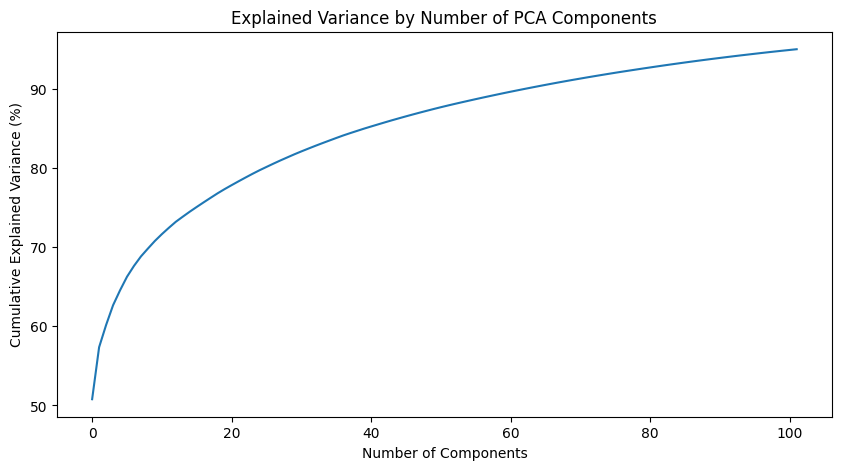

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of PCA Components')
plt.show()

The plot shows how much variance is explained as we include more principal components. This helps in understanding the trade-off between the number of components and the amount of information retained.

## Clustering

Determining Optimal Number of Clusters
To decide the appropriate number of clusters, we'll use:

* Elbow Method
* Silhouette Score


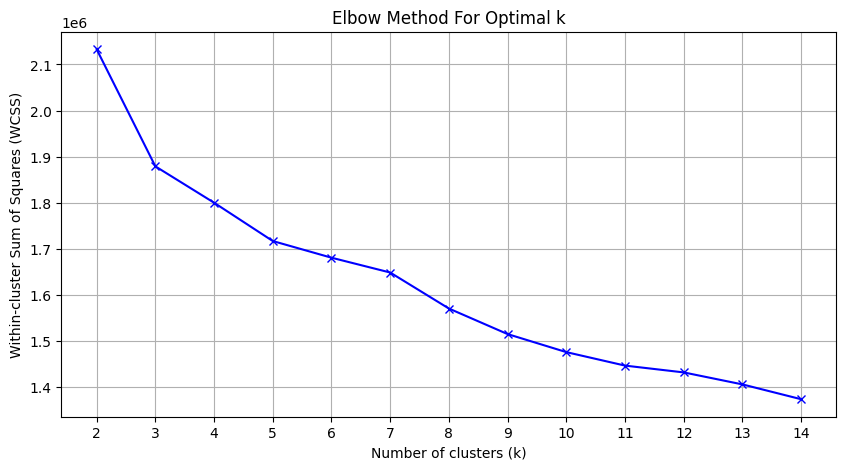

In [15]:
# Elbow Method
wcss = []  # Within-cluster sum of squares
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
    kmeans.fit(X_train_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 5))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

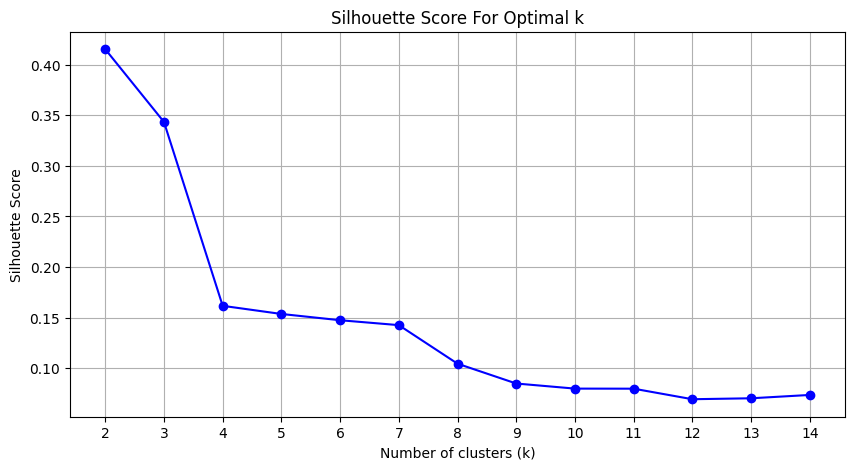

In [16]:
# Silhouette Score
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
    cluster_labels = kmeans.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

### Choosing the Number of Clusters

From both the elbow and silhouette score methods, we have the following observations:

- **Elbow Method**: The "elbow" point is around **k = 6**, but there is also a slower decline in WCSS up to **k = 9**, suggesting **k = 9** could also be a reasonable choice.
- **Silhouette Score**: The silhouette score is highest at **k = 6**, but the difference is not significant compared to **k = 9**, indicating that **k = 9** might still produce well-separated clusters.

Given that there are **6 known activities** in the dataset, **k = 6** is an interpretable choice that directly matches these activities. However, the clustering analysis suggests that **k = 9** might reveal sub-groups within these actision**:
We will explore both **k = 6** and **k = 9** for clustering:
- **k = 6** to match known activities for a simpler interpretation.
- **k = 9** to potentially uncover more granular sub-groups within , which may yield deeper insights to activity variations.ariations.


## Applying K-Means Clustering with **k = 6** (aligned with the known activities) and **k = 9** (to explore potential sub-groups)


In [17]:
# K-Means for k = 6
kmeans_6 = KMeans(n_clusters=6, random_state=42, n_init='auto')
kmeans_6.fit(X_train_pca)
labels_6 = kmeans_6.labels_

# Calculate silhouette score for k = 6
silhouette_6 = silhouette_score(X_train_pca, labels_6)
print(f'Silhouette Score for k=6: {silhouette_6:.2f}')

# K-Means for k = 9
kmeans_9 = KMeans(n_clusters=9, random_state=42, n_init='auto')
kmeans_9.fit(X_train_pca)
labels_9 = kmeans_9.labels_

# Calculate silhouette score for k = 9
silhouette_9 = silhouette_score(X_train_pca, labels_9)
print(f'Silhouette Score for k=9: {silhouette_9:.2f}')

Silhouette Score for k=6: 0.15
Silhouette Score for k=9: 0.08


### Observations

- The silhouette score for **k = 6** is higher than that for **k = 9**, suggesting that using **k = 6** results in better-defined clusters. This aligns with the fact that there are 6 distinct activities in the dataset, making **k = 6** a more interpretable and practical choice.
- While using **k = 9** may have seemed promising to capture sub-groups, the lower silhouette score indicates that these additional clusters do not provide a significant improvement in cluster quality. Instead, they may create more noise or ambiguity in the clustering.
- Based on the results, we choose **k = 6** as the final number of clusters since it aligns with the known activities and provides a better silhouette score, resulting in more clearly separated and interpretable clusters.

### Visualize Clusters Using t-SNE

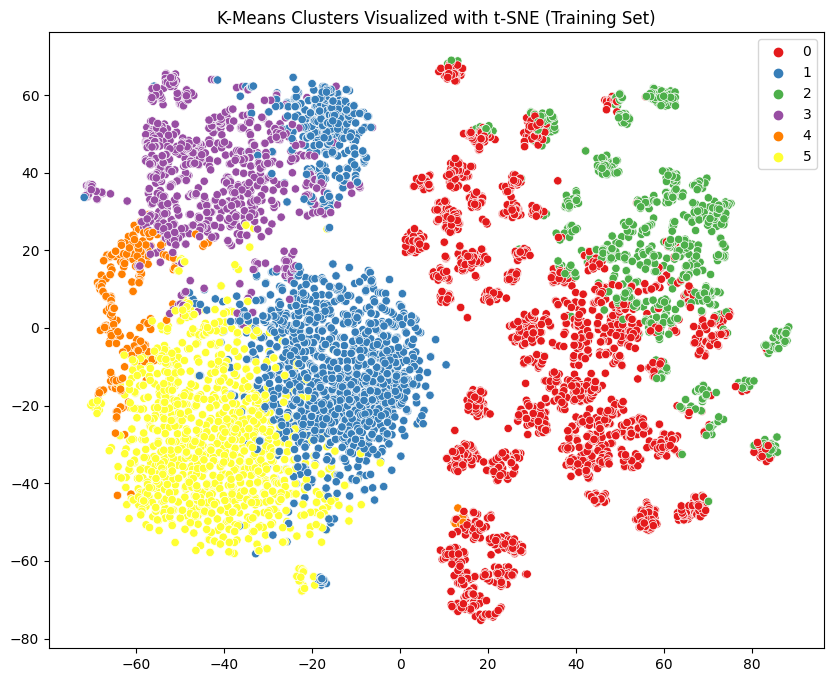

In [18]:
# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=labels_6, palette='Set1', legend='full')
plt.title('K-Means Clusters Visualized with t-SNE (Training Set)')
plt.show()

## K-Means Clustering Evaluation

Though its not very important in this case, lets predict Test Set Cluster Labels for K-Means

In [19]:
# Predict cluster labels for the test set using K-Means
kmeans_test_labels = kmeans_6.predict(X_test_pca)

Map Cluster Labels to Activity Labels for K-Means

In [20]:
def map_cluster_labels(true_labels, cluster_labels):
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        labels_in_cluster = true_labels[mask]
        # Use Counter to find the most common label
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        label_mapping[cluster] = most_common_label
    return label_mapping

# K-Means Clustering Evaluation for Training Set
# Map for training set using labels_6
kmeans_label_mapping_train = map_cluster_labels(y_train['Activity'].values, labels_6)
print("Cluster to Activity Mapping for K-Means (Training Set):", kmeans_label_mapping_train)

# Map cluster labels to activity labels for training set using labels_6
kmeans_train_pred_labels = [kmeans_label_mapping_train.get(label, 0) for label in labels_6]

# Classification report for training set
print("K-Means Classification Report (Training Set):")
print(classification_report(y_train['Activity'], kmeans_train_pred_labels, target_names=activity_labels.values(), zero_division=0))

# Adjusted Rand Index for training set
kmeans_ari_train = adjusted_rand_score(y_train['Activity'], labels_6)
print(f"K-Means Adjusted Rand Index (Training Set): {kmeans_ari_train:.3f}")

# Silhouette Score for training set
kmeans_silhouette_train = silhouette_score(X_train_pca, labels_6)
print(f"K-Means Silhouette Score (Training Set): {kmeans_silhouette_train:.3f}")


# Map cluster labels to activity labels for test set using the label mapping from training
kmeans_test_pred_labels = [kmeans_label_mapping_train.get(label, 0) for label in kmeans_test_labels]

# Classification report for test set
print("K-Means Classification Report (Test Set):")
print(classification_report(y_test['Activity'], kmeans_test_pred_labels, target_names=activity_labels.values(), zero_division=0))

# Adjusted Rand Index for test set
kmeans_ari_test = adjusted_rand_score(y_test['Activity'], kmeans_test_labels)
print(f"K-Means Adjusted Rand Index (Test Set): {kmeans_ari_test:.3f}")

# Silhouette Score for test set
kmeans_silhouette_test = silhouette_score(X_test_pca, kmeans_test_labels)
print(f"K-Means Silhouette Score (Test Set): {kmeans_silhouette_test:.3f}")

Cluster to Activity Mapping for K-Means (Training Set): {0: 2, 1: 4, 2: 3, 3: 6, 4: 6, 5: 5}
K-Means Classification Report (Training Set):
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00      1226
  WALKING_UPSTAIRS       0.41      0.90      0.56      1073
WALKING_DOWNSTAIRS       0.56      0.53      0.54       986
           SITTING       0.42      0.53      0.47      1286
          STANDING       0.61      0.57      0.59      1374
            LAYING       0.84      0.71      0.77      1407

          accuracy                           0.54      7352
         macro avg       0.48      0.54      0.49      7352
      weighted avg       0.49      0.54      0.50      7352

K-Means Adjusted Rand Index (Training Set): 0.349
K-Means Silhouette Score (Training Set): 0.147
K-Means Classification Report (Test Set):
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00       49

### Observations

#### Training Set
- The cluster-to-activity mapping shows that K-Means clustering does not align perfectly with the actual activities. Some clusters have multiple assigned activity labels, indicating significant overlap between activities.
- The classification report for the training set indicates that `WALKING` has the lowest precision and recall (both **0.00**), suggesting that this activity is challenging for the model to identify effectively.
- Activities such as `LAYING` exhibit higher precision and recall, implying that these activities are more distinct and easier to identify.
- The overall accuracy for the training set is **0.54**, and the weighted average F1-score is **0.50**, indicating moderate clustering success.
- The Adjusted Rand Index (ARI) of **0.349** shows moderate alignment between the true activity labels and the clustering assignments.

#### Test Set
- The test set evaluation results are consistent with the training set, with an overall accuracy of **0.56** and a weighted average F1-score of **0.51**.
- The Adjusted Rand Index (ARI) for the test set is **0.382**, which is slightly better than the training set, indicating a marginal improvement in clustering quality.
- The Silhouette Score for both the training and test sets is **0.147**, suggesting that the clusters are not very well-defined, and there is significant overlap between them.

#### Challenges
- **Challenges**: The low silhouette score and inconsistent cluster-to-activity mapping indicate that certain activities (e.g., `WALKING`, `WALKING_UPSTAIRS`, `WALKING_DOWNSTAIRS`) have overlapping characteristics, making it difficult for K-Means to differentiate between them effectively.


## Comparison of Different Clustering Algorithms

Lets see how other clustering algorithms fare . Also since most of these clustering algorithms don't have a seperate predict method we will stick to evaluating only on the training data as this is unsupervised learning and therefore the labels don't actually matter.

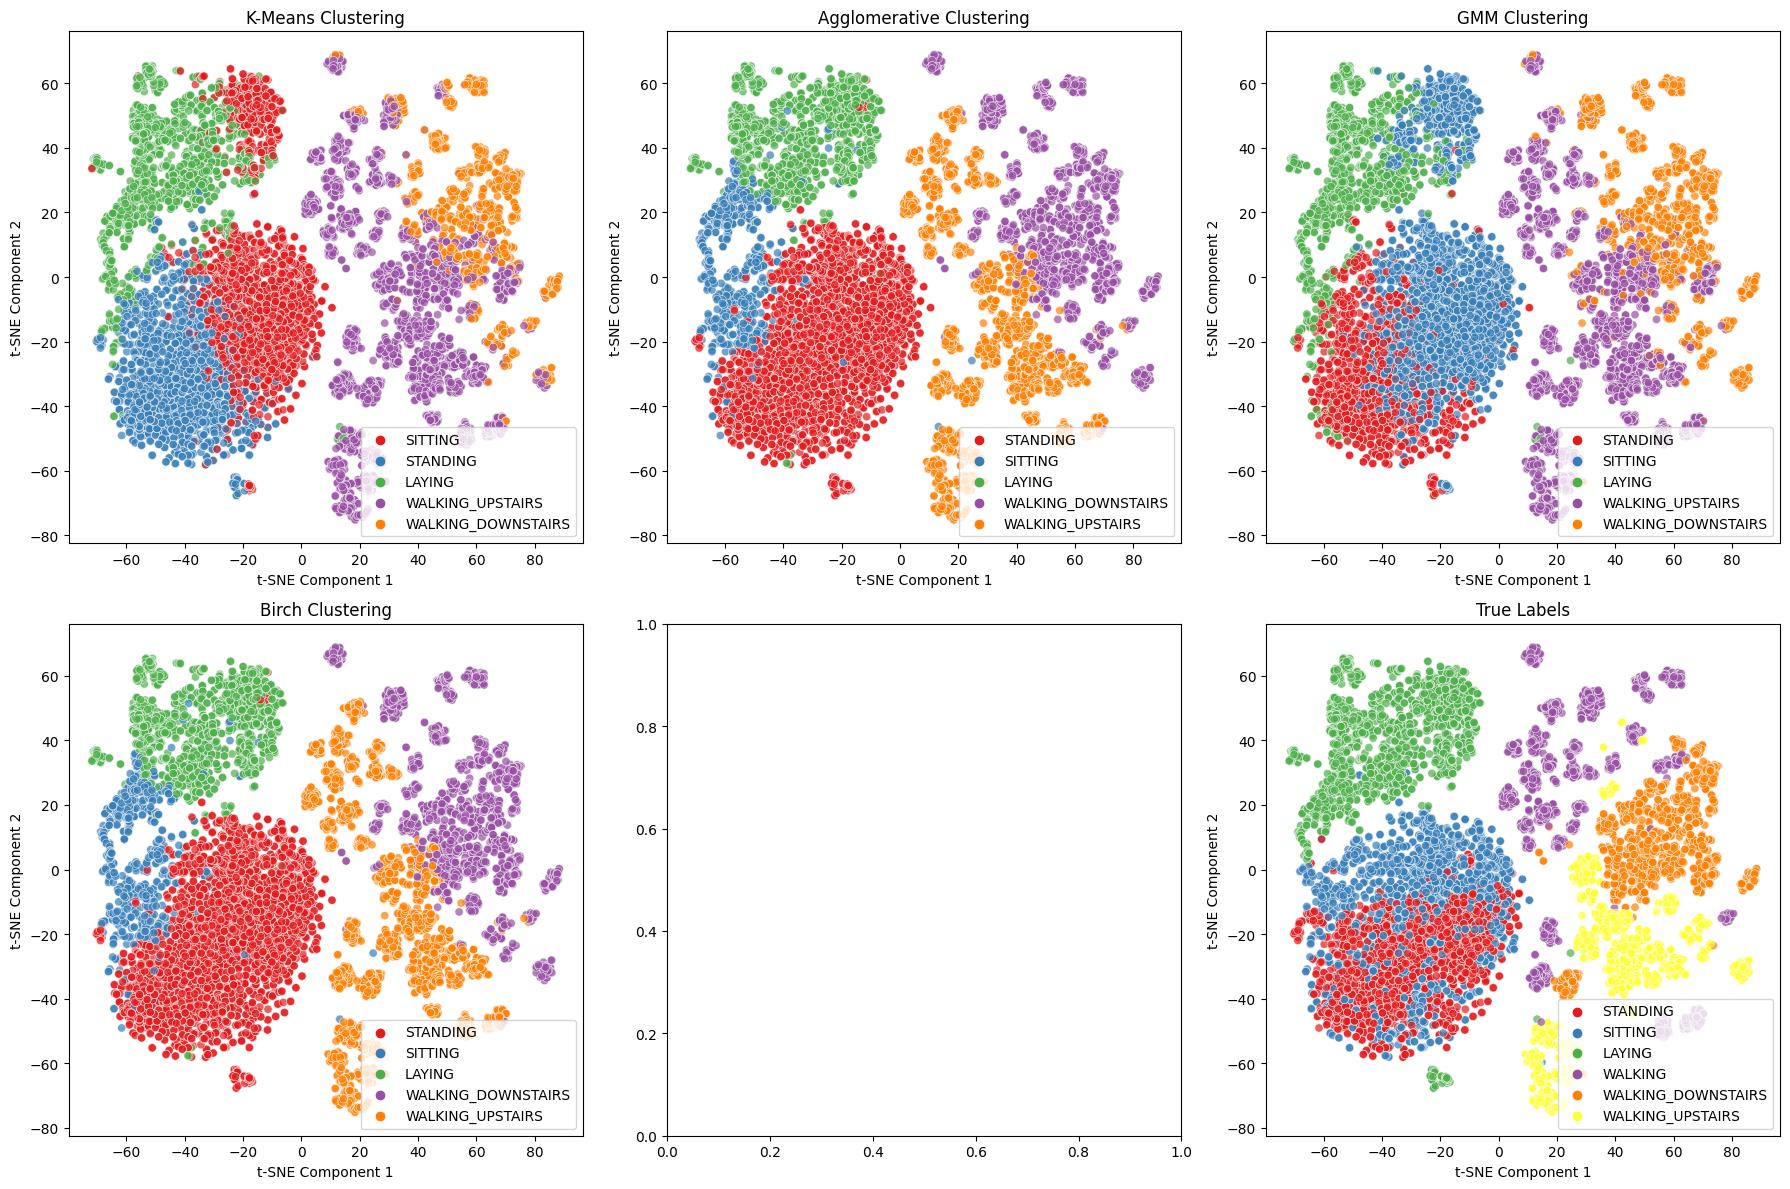

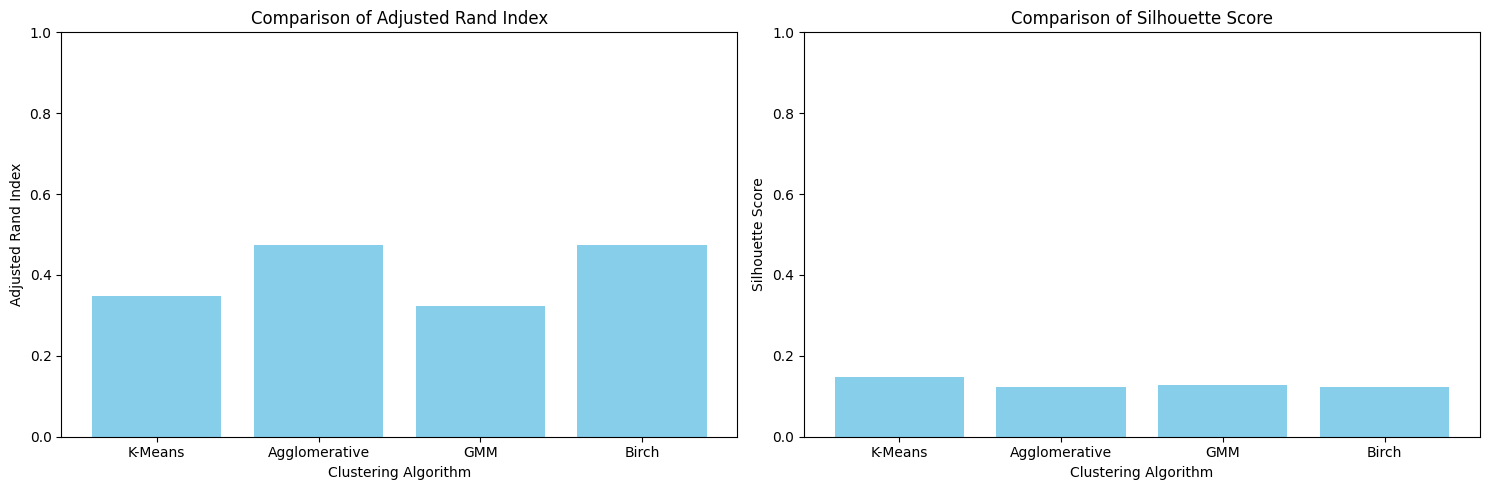

In [21]:
# Function to map cluster labels to ground truth labels
def map_cluster_labels(true_labels, cluster_labels):
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        labels_in_cluster = true_labels[mask]
        # Use Counter to find the most common label
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        label_mapping[cluster] = most_common_label
    return label_mapping

# Container to store clustering performance metrics
performance_metrics = []

# Fit t-SNE to visualize clusters in 2D
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

# Helper function for cluster visualization
def visualize_clusters(title, labels, tsne_data, ax, activity_names):
    sns.scatterplot(
        x=tsne_data[:, 0],
        y=tsne_data[:, 1],
        hue=[activity_names.get(label, 'Noise') for label in labels],
        palette='Set1',
        legend='full',
        ax=ax,
        alpha=0.7
    )
    ax.set_title(title)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')

# List of clustering algorithms to evaluate
clustering_algorithms = [
    ('K-Means', KMeans(n_clusters=6, random_state=42, n_init='auto')),
    ('Agglomerative', AgglomerativeClustering(n_clusters=6)),
    ('GMM', GaussianMixture(n_components=6, random_state=42)),
    ('Birch', Birch(n_clusters=6))
]

# Set up plotting for t-SNE visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Evaluate and visualize each clustering algorithm
for i, (name, algorithm) in enumerate(clustering_algorithms):
    if name == 'GMM':
        labels = algorithm.fit_predict(X_train_pca)  # For GMM use fit_predict
    else:
        labels = algorithm.fit(X_train_pca).labels_ if hasattr(algorithm, 'labels_') else algorithm.fit_predict(X_train_pca)

    if len(set(labels)) > 1:
        label_mapping = map_cluster_labels(y_train['Activity'].values, labels)
        ari = adjusted_rand_score(y_train['Activity'], labels)
        silhouette = silhouette_score(X_train_pca, labels)
    else:
        ari, silhouette = 0, 0  # Handle cases where only one label is present

    # Store performance metrics for visualization
    performance_metrics.append((name, ari, silhouette))

    # Map cluster labels to activity labels for visualization
    mapped_labels = [label_mapping.get(label, 0) for label in labels]
    activity_names = activity_labels

    # Visualize clusters with t-SNE
    visualize_clusters(f'{name} Clustering', mapped_labels, X_train_tsne, axes[i], activity_names)

# Visualize the actual labels based on true training data
true_labels = y_train['Activity'].values
visualize_clusters('True Labels', true_labels, X_train_tsne, axes[-1], activity_labels)

# Adjust the layout of subplots
plt.tight_layout()
plt.show()

# Visualize Clustering Performance Metrics
metrics_names = ['Adjusted Rand Index', 'Silhouette Score']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, metric_name in enumerate(metrics_names):
    values = [metric[i + 1] for metric in performance_metrics]
    axes[i].bar([metric[0] for metric in performance_metrics], values, color='skyblue')
    axes[i].set_title(f'Comparison of {metric_name}')
    axes[i].set_xlabel('Clustering Algorithm')
    axes[i].set_ylabel(metric_name)
    axes[i].set_ylim(0, 1)  # Set y-limit to better visualize the differences

plt.tight_layout()
plt.show()

### Comparison of Different Clustering Algorithms

In this section, we compared four clustering algorithms: **K-Means**, **Agglomerative Clustering**, **Gaussian Mixture Model (GMM)**, and **BIRCH**. Below are the observations and conclusions based on the t-SNE visualizations and clustering metrics:

#### t-SNE Visualizations:
- **K-Means**: The clusters showed significant overlap, especially for activities like `WALKING_UPSTAIRS` and `WALKING_DOWNSTAIRS`. This indicates that K-Means struggled to differentiate these similar activities.
- **Agglomerative Clustering**: Showed better-defined clusters compared to K-Means. Activities like `STANDING` and `LAYING` had more distinct boundaries.
- **GMM**: Produced compact clusters but still showed some overlap. It was moderately successful in clustering, comparable to Agglomerative Clustering.
- **BIRCH**: Displayed the most distinct clusters, suggesting that it was effective in grouping activities even with subtle variations.

#### Performance Metrics:
- **Adjusted Rand Index (ARI)**:
  - **BIRCH** had the highest ARI, indicating the best agreement with true activity labels.
  - **Agglomerative Clustering** also performed well, with an ARI close to BIRCH.
  - **K-Means** had the lowest ARI, reflecting its difficulty in accurately clustering the data.
- **Silhouette Score**:
  - All clustering algorithms had relatively low silhouette scores, indicating that intra-cluster cohesion was not ideal, likely due to overlapping activity characteristics.

## Conclusion:
- **BIRCH** was the best-performing algorithm based on the ARI, making it the preferred method for this dataset.
- **Agglomerative Clustering** also provided competitive results and could be a good alternative.